In [ ]:
!pip install torch torchvision

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torch.utils.data import DataLoader

In [ ]:
from torchvision.models import mobilenet_v3_small  # 모델 크기에 따라 선택 가능 (small, large)


In [ ]:
# 데이터셋 경로 설정
data_path = './data'  # 데이터셋을 저장할 경로

# 전처리 및 데이터 로드
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

train_dataset = datasets.CIFAR10(root=data_path, train=True, transform=transform, download=True)
test_dataset = datasets.CIFAR10(root=data_path, train=False, transform=transform, download=True)

batch_size = 32

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size)


Files already downloaded and verified
Files already downloaded and verified


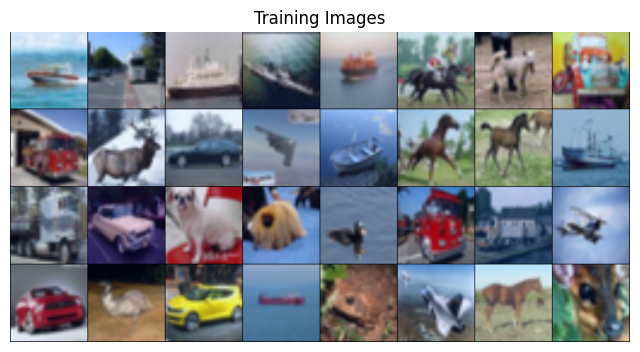

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import torchvision.utils as utils

# CIFAR-10 데이터셋에서 무작위로 이미지를 가져옴
dataiter = iter(train_loader)
images, labels = next(dataiter)

# train 이미지 시각화
plt.figure(figsize=(8, 8))
plt.axis("off")
plt.title("Training Images")
plt.imshow(np.transpose(utils.make_grid(images[:64], padding=2, normalize=True), (1, 2, 0)))
plt.show()


In [ ]:
# MobileNetV3 모델 불러오기
model = mobilenet_v3_small(pretrained=True)


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V3_Small_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V3_Small_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/mobilenet_v3_small-047dcff4.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v3_small-047dcff4.pth
100%|██████████| 9.83M/9.83M [00:00<00:00, 41.3MB/s]


In [ ]:
# 분류기 (마지막 레이어) 수정
num_classes = 10  # CIFAR-10 클래스 수
model.classifier[3] = nn.Linear(model.classifier[3].in_features, num_classes)

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)


In [ ]:
# 학습 설정
num_epochs = 20
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# 학습 루프
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0 # total loss
    correct = 0
    total = 0

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    train_accuracy = 100 * correct /total
    print(f'Epoch [{epoch+1}/{num_epochs}] Train Loss: {running_loss/len(train_loader):.4f} Train Accuracy: {train_accuracy:.2f}%')

# 테스트
model.eval()
correct = 0
total = 0
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

accuracy = correct / total
print(f"Accuracy on test set: {100 * accuracy:.2f}%")


Epoch [1/20] Train Loss: 0.4265 Train Accuracy: 85.39%


In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# 테스트 데이터로 예측 수행
model.eval()
test_predictions = []
test_labels = []

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)
        test_predictions.extend(predicted.cpu().numpy())
        test_labels.extend(labels.cpu().numpy())

# 클래스 레이블과 예측 결과를 이용한 혼동 행렬(confusion matrix) 생성
from sklearn.metrics import confusion_matrix
import seaborn as sns

cm = confusion_matrix(test_labels, test_predictions)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")
plt.show()

# 각 클래스에 대한 정확도 및 다른 성능 지표 시각화
from sklearn.metrics import classification_report

class_names = [str(i) for i in range(len(train_dataset.classes))]
report = classification_report(test_labels, test_predictions, target_names=class_names, output_dict=True)

# 클래스별 정확도 시각화
accuracies = [report[class_name]['precision'] for class_name in class_names]
plt.figure(figsize=(10, 5))
plt.bar(class_names, accuracies, color='skyblue')
plt.xlabel('Class')
plt.ylabel('Precision')
plt.title('Precision by Class')
plt.xticks(rotation=45)
plt.show()

# 클래스별 재현율 시각화
recalls = [report[class_name]['recall'] for class_name in class_names]
plt.figure(figsize=(10, 5))
plt.bar(class_names, recalls, color='lightcoral')
plt.xlabel('Class')
plt.ylabel('Recall')
plt.title('Recall by Class')
plt.xticks(rotation=45)
plt.show()

# 전체 정확도 및 다른 성능 지표 출력
print("Overall Metrics:")
print(classification_report(test_labels, test_predictions, target_names=class_names))

# 특정 이미지의 예측 시각화
def plot_image_predictions(images, labels, predictions, class_names):
    plt.figure(figsize=(12, 6))
    for i in range(min(len(images), 6)):
        plt.subplot(2, 3, i + 1)
        plt.imshow(np.transpose(images[i], (1, 2, 0)))
        plt.title(f'True: {class_names[labels[i]]}\nPredicted: {class_names[predictions[i]]}')
        plt.axis('off')
    plt.tight_layout()
    plt.show()

# 테스트 데이터에서 무작위 이미지 예측 시각화
random_indices = np.random.choice(len(test_dataset), size=6, replace=False)
sample_images = [test_dataset[i][0] for i in random_indices]
sample_labels = [test_labels[i] for i in random_indices]
sample_predictions = [test_predictions[i] for i in random_indices]
plot_image_predictions(sample_images, sample_labels, sample_predictions, class_names)


In [ ]:
import random

# 무작위로 8개의 테스트 이미지를 선택
num_samples = 8
random_indices = random.sample(range(len(test_dataset)), num_samples)
sample_images = [test_dataset[i][0] for i in random_indices]
sample_labels = [test_labels[i] for i in random_indices]

# 선택된 이미지에 대한 모델의 예측 수행
model.eval()
sample_predictions = []
with torch.no_grad():
    for image in sample_images:
        image = image.unsqueeze(0).to(device)  # 배치 차원 추가 및 GPU로 전송
        output = model(image)
        _, predicted = torch.max(output, 1)
        sample_predictions.append(predicted.item())

# 선택된 이미지와 예측을 시각화
class_names = [str(i) for i in range(len(train_dataset.classes))]

plt.figure(figsize=(16, 10))
for i in range(num_samples):
    plt.subplot(2, 4, i + 1)
    plt.imshow(np.transpose(sample_images[i], (1, 2, 0)))
    true_label = class_names[sample_labels[i]]
    predicted_label = class_names[sample_predictions[i]]
    plt.title(f'True: {true_label}\nPredicted: {predicted_label}', fontsize=12)
    plt.axis('off')

plt.tight_layout()
plt.show()


In [ ]:
import seaborn as sns
from sklearn.metrics import confusion_matrix

# 테스트 데이터로 예측 수행
model.eval()
test_predictions = []
test_labels = []

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)
        test_predictions.extend(predicted.cpu().numpy())
        test_labels.extend(labels.cpu().numpy())

# 클래스 레이블과 예측 결과를 이용한 혼동 행렬 생성
class_names = [str(i) for i in range(len(train_dataset.classes))]
cm = confusion_matrix(test_labels, test_predictions)

# 혼동 행렬 시각화
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")
plt.show()
